In [1]:
! pip install opendatasets --upgrade --quiet
! pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import pandas as pd
import os
import opendatasets as od

In [3]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import tqdm
from torch.utils import data
from torch.utils.data import DataLoader
import cv2
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet


target_shape = (200, 200)

In [5]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/c/11-785-fall-20-homework-2-part-2'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satoutakara
Your Kaggle Key: ··········


100%|██████████| 1.35G/1.35G [01:12<00:00, 19.8MB/s]



Extracting archive ./11-785-fall-20-homework-2-part-2/11-785-fall-20-homework-2-part-2.zip to ./11-785-fall-20-homework-2-part-2


In [6]:
max_folders = 4000
max_images_per_folder = 14

In [7]:
import os
import cv2
import numpy as np

def load_data(data_path):
    # Loads data and preprocesses it, returns train and test data along with labels
    anchor_images = []
    positive_images = []

    print('Loading Data from File ', end='')
    folder_count = 0
    for folder in os.listdir(data_path):
        path = os.path.join(data_path, folder)
        # print(folder, end='|')
        image_count = 1
        for image in os.listdir(path):
            if image_count%2!=0 and image_count == len(os.listdir(path)):
                break
            if image_count%2!=0:
                anchor_images.append(os.path.join(path, image))
            else:
                positive_images.append(os.path.join(path, image))
            image_count += 1

        folder_count += 1

    return anchor_images, positive_images

In [8]:
base_path = '/content/11-785-fall-20-homework-2-part-2/'
train_path = os.path.join(base_path, 'classification_data/train_data')

val_file_path = os.path.join(base_path, 'verification_pairs_val.txt')
test_file_path = os.path.join(base_path, 'verification_pairs_test.txt')

In [9]:
# Extract train images and labels
anchor_images, positive_images = load_data(train_path)

Loading Data from File 

In [10]:
print(len(anchor_images))
print(len(positive_images))

189380
189380


In [11]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it, resize it to the target shape,
    and normalize it.
    """

    # Load the image
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Convert image to float32 and resize
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)

    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [12]:
image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

import random

# Ensure that anchor_images and positive_images are lists or similar iterable types
anchor_images = list(anchor_images)
positive_images = list(positive_images)

# Set random seed for reproducibility
random.seed(42)

# Create a list of indices
indices = list(range(len(anchor_images)))

# Shuffle the indices
random.shuffle(indices)

# Use the shuffled indices to reorder both lists
anchor_images = [anchor_images[i] for i in indices]
positive_images = [positive_images[i] for i in indices]

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(256, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

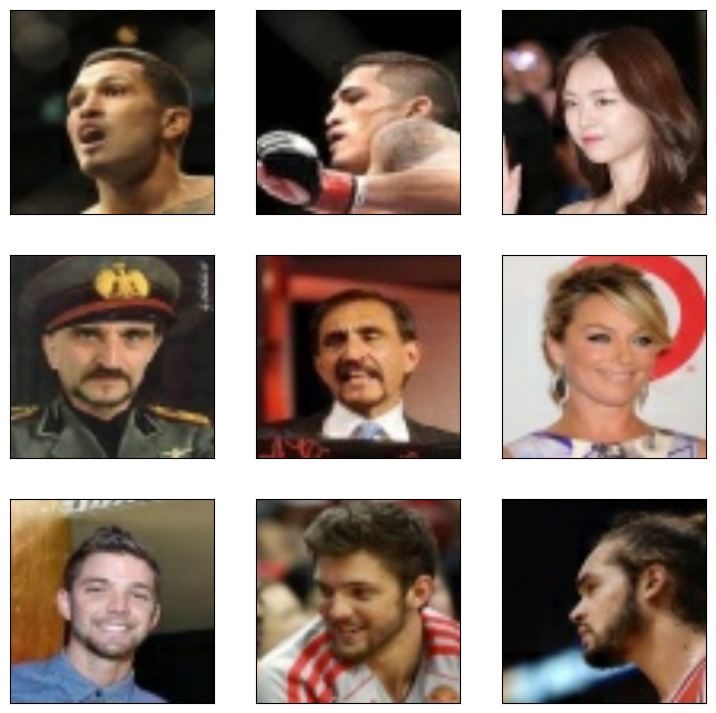

In [13]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [14]:
import os
import tensorflow as tf

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it, resize it to the target shape,
    and normalize it.
    """

    # Load the image
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Convert image to float32 and resize
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)

    return image

def preprocess_image_pair_label(pair, label):
    return (
        preprocess_image(pair[0]),
        preprocess_image(pair[1]),
        label,
    )

def load_val_verification_data(file_path, image_dir, batch_size):
    pairs = []
    labels = []

    with open(file_path, 'r') as f:
        for line in f:
            pair = line.strip().split()
            pairs.append((os.path.join(image_dir, pair[0]), os.path.join(image_dir, pair[1])))  # Convert list to tuple
            labels.append(float(pair[2]))

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((pairs, labels))
    dataset = dataset.map(preprocess_image_pair_label)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [15]:
test_dataset = load_val_verification_data(val_file_path, base_path, 256)

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
siamese_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 200, 200, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 200, 200, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 75,168,640 (286.75 MB)

 Trainable params: 60,510,720 (230.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

    @classmethod
    def from_config(cls, config):
        # Extract necessary parameters from the config dictionary
        # and create a new instance of the SiameseModel class
        # Example:
        # param1 = config['param1']
        # param2 = config['param2']
        # return cls(param1, param2)
        return cls(**config)

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=4, validation_data=val_dataset)

Epoch 1/4
592/592 ━━━━━━━━━━━━━━━━━━━━ 908s 1s/step - loss: 0.3991 - val_loss: 0.3429
Epoch 2/4
592/592 ━━━━━━━━━━━━━━━━━━━━ 817s 1s/step - loss: 0.3304 - val_loss: 0.3178
Epoch 3/4
592/592 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - loss: 0.3121 - val_loss: 0.3093
Epoch 4/4
592/592 ━━━━━━━━━━━━━━━━━━━━ 763s 1s/step - loss: 0.3037 - val_loss: 0.2999


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the embedding model
embedding.save('embedding_metric.h5')  # or 'embedding_model' for SavedModel format

In [ ]:
import shutil

# Define the path to the saved model and the destination path in Google Drive
model_path = 'embedding_metric.h5'  # or 'siamese_model.h5'
drive_path = '/content/drive/My Drive/Applied ML/project/embedding_metric.h5'  # or 'siamese_model.h5'

# Ensure the destination directory exists
import os
os.makedirs(os.path.dirname(drive_path), exist_ok=True)

# Move the model file to Google Drive
shutil.move(model_path, drive_path)

'/content/drive/My Drive/Applied ML/project/siamese_model.h5'

In [17]:
from tensorflow.keras.models import load_model

drive_path = '/content/drive/My Drive/Applied ML/project/embedding_metric.h5'  # or 'siamese_model.h5'

embedding = load_model(drive_path)

embedding.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 206, 206, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 50, 50, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 50, 50, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 50, 50, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 75,168,640 (286.75 MB)

 Trainable params: 60,510,720 (230.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [ ]:
# Define the PairDistanceLayer and create the pair_model
class PairDistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, image1, image2):
        distance = 1 - ops.sum(tf.square(image1 - image2), -1)
        return distance

In [ ]:
# Define the input layers
image1_input = layers.Input(name="image1", shape=target_shape + (3,))
image2_input = layers.Input(name="image2", shape=target_shape + (3,))

# embedding = siamese_model.siamese_network.get_layer(name="Embedding")

# Assuming 'embedding' and 'resnet' are defined elsewhere
embedding1 = embedding(resnet.preprocess_input(image1_input))
embedding2 = embedding(resnet.preprocess_input(image2_input))

# Apply the PairDistanceLayer
similarity_scores = PairDistanceLayer()(
    image1=embedding1,
    image2=embedding2
)

# Create the model
pair_model = Model(inputs=[image1_input, image2_input], outputs=similarity_scores)

In [ ]:
# Compute similarity scores for the test set
def compute_similarity_scores(pair_model, test_dataset):
    similarity_scores = []
    true_labels = []
    for image1, image2, label in test_dataset:
        similarity_score = pair_model.predict([image1, image2])
        similarity_scores.append(similarity_score)
        true_labels.append(label.numpy())
    similarity_scores = np.concatenate(similarity_scores)
    true_labels = np.concatenate(true_labels)
    return similarity_scores, true_labels

# Assuming 'test_dataset' is the test dataset obtained from load_val_verification_data
similarity_scores, true_labels = compute_similarity_scores(pair_model, test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8/8 ━━━━━

In [ ]:
import numpy as np

# Assuming array is your NumPy array
array = similarity_scores

# Calculate statistics
mean_value = np.mean(array)
std_dev = np.std(array)
min_value = np.min(array)
max_value = np.max(array)
median_value = np.median(array)
percentile_25 = np.percentile(array, 25)
percentile_75 = np.percentile(array, 75)

# Print statistics
print("Mean:", mean_value)
print("Standard Deviation:", std_dev)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Median:", median_value)
print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

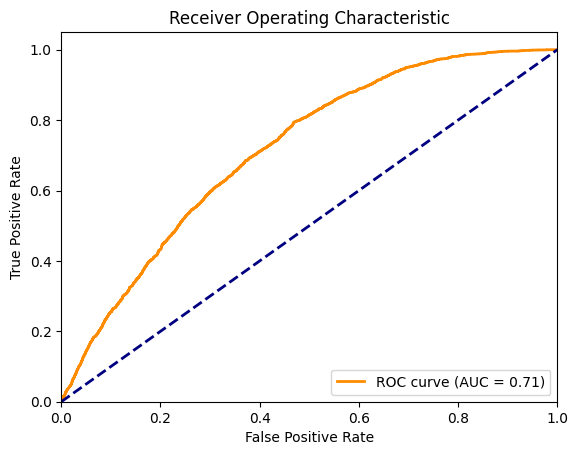

Test AUC: 0.71


In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot the ROC curve and calculate AUC
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

roc_auc = plot_roc_curve(true_labels, similarity_scores)
print("Test AUC: {:.2f}".format(roc_auc))